In [3]:
import torch
import torchvision.transforms as transforms
from data_loader import load_cifar
from torch.utils.data import Dataset, DataLoader, random_split

class CIFARDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        instance = self.data[idx]
        image = instance['image']
        label = instance['label']

        if self.transform:
            image = self.transform(image)

        return image, label

train_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load data using data_loader
data = load_cifar()

# Create datasets
train_dataset = CIFARDataset(data['train'], transform=train_transform)
test_dataset = CIFARDataset(data['test'], transform=test_transform)

# Split training data into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print('Number of training samples:', len(train_set))
print('Number of validation samples:', len(val_set))
print('Number of test samples:', len(test_dataset))


Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 128, 5, padding=2)
    self.conv2 = nn.Conv2d(128, 128, 5, padding=2)
    self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.bn_conv1 = nn.BatchNorm2d(128)
    self.bn_conv2 = nn.BatchNorm2d(128)
    self.bn_conv3 = nn.BatchNorm2d(256)
    self.bn_conv4 = nn.BatchNorm2d(256)
    self.bn_dense1 = nn.BatchNorm1d(1024)
    self.bn_dense2 = nn.BatchNorm1d(512)
    self.dropout_conv = nn.Dropout2d(p=0.25)
    self.dropout = nn.Dropout(p=0.5)
    self.fc1 = nn.Linear(256 * 8 * 8, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 10)

  def conv_layers(self, x):
    out = F.relu(self.bn_conv1(self.conv1(x)))
    out = F.relu(self.bn_conv2(self.conv2(out)))
    out = self.pool(out)
    out = self.dropout_conv(out)
    out = F.relu(self.bn_conv3(self.conv3(out)))
    out = F.relu(self.bn_conv4(self.conv4(out)))
    out = self.pool(out)
    out = self.dropout_conv(out)
    return out

  def dense_layers(self, x):
    out = F.relu(self.bn_dense1(self.fc1(x)))
    out = self.dropout(out)
    out = F.relu(self.bn_dense2(self.fc2(out)))
    out = self.dropout(out)
    out = self.fc3(out)
    return out

  def forward(self, x):
    out = self.conv_layers(x)
    out = out.view(-1, 256 * 8 * 8)
    out = self.dense_layers(out)
    return out

net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
net.to(device)

num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

Device: cuda:0
Number of trainable parameters: 18617482


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr=0)

loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

for epoch in range(140):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))



[epoch 1] loss: 0.01424 accuracy: 0.3425 val loss: 0.01224 val accuracy: 0.4247
[epoch 2] loss: 0.01168 accuracy: 0.4567 val loss: 0.01042 val accuracy: 0.5261
[epoch 3] loss: 0.01052 accuracy: 0.5131 val loss: 0.00921 val accuracy: 0.5813
[epoch 4] loss: 0.00940 accuracy: 0.5702 val loss: 0.00800 val accuracy: 0.6360
[epoch 5] loss: 0.00852 accuracy: 0.6179 val loss: 0.00700 val accuracy: 0.6925
[epoch 6] loss: 0.00784 accuracy: 0.6493 val loss: 0.00667 val accuracy: 0.7001
[epoch 7] loss: 0.00733 accuracy: 0.6725 val loss: 0.00616 val accuracy: 0.7206
[epoch 8] loss: 0.00697 accuracy: 0.6912 val loss: 0.00597 val accuracy: 0.7368
[epoch 9] loss: 0.00665 accuracy: 0.7032 val loss: 0.00544 val accuracy: 0.7624
[epoch 10] loss: 0.00630 accuracy: 0.7214 val loss: 0.00547 val accuracy: 0.7588
[epoch 11] loss: 0.00607 accuracy: 0.7315 val loss: 0.00536 val accuracy: 0.7619
[epoch 12] loss: 0.00586 accuracy: 0.7421 val loss: 0.00507 val accuracy: 0.7771
[epoch 13] loss: 0.00565 accuracy: 0.

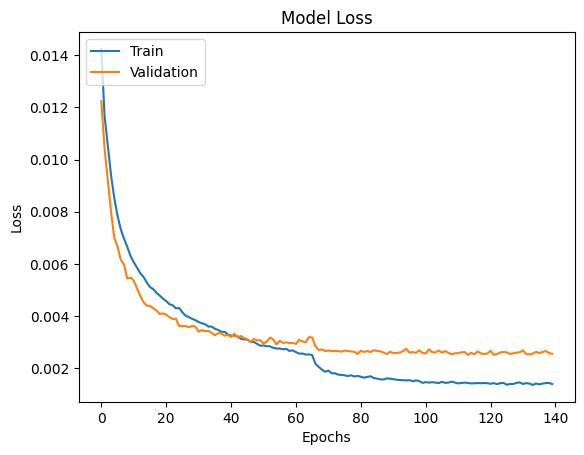

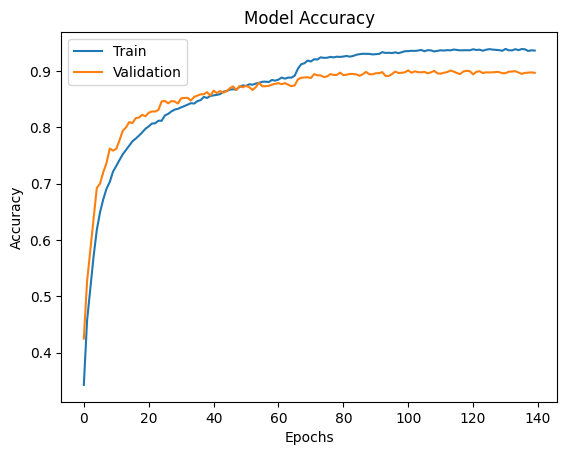

In [6]:
import matplotlib.pyplot as plt

legend = ['Train', 'Validation']
plt.plot(loss_hist)
plt.plot(loss_hist_val)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train', 'Validation']
plt.plot(acc_hist)
plt.plot(acc_hist_val)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

In [8]:
pred_vec = []
true_vec = []
correct = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = net(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
        true_vec.append(labels)
    pred_vec = torch.cat(pred_vec)
    true_vec = torch.cat(true_vec)

# Convert to CPU and numpy for easier calculation
pred_np = pred_vec.cpu().numpy()
true_np = true_vec.cpu().numpy()

# Calculate confusion matrix
num_classes = 10
confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)
for t, p in zip(true_np, pred_np):
    confusion_matrix[t, p] += 1

# Calculate metrics
precision_per_class = []
recall_per_class = []
f1_per_class = []
support = []

print('Per-class metrics:')
for i in range(num_classes):
    # True positives, false positives, false negatives
    tp = confusion_matrix[i, i]
    fp = confusion_matrix[:, i].sum() - tp
    fn = confusion_matrix[i, :].sum() - tp

    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    class_support = int(confusion_matrix[i, :].sum())

    precision_per_class.append(precision)
    recall_per_class.append(recall)
    f1_per_class.append(f1)
    support.append(class_support)

    print(f'Class {i}:')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    print(f'  F1 Score: {f1:.4f}')
    print(f'  Support: {class_support}')

# Calculate weighted averages
total_samples = sum(support)
weighted_precision = sum(p * s for p, s in zip(precision_per_class, support)) / total_samples
weighted_recall = sum(r * s for r, s in zip(recall_per_class, support)) / total_samples
weighted_f1 = sum(f * s for f, s in zip(f1_per_class, support)) / total_samples

print('\nOverall metrics:')
print('Accuracy: %.2f%%' % (100 * correct / len(test_dataset)))
print('Weighted Precision: %.4f' % weighted_precision)
print('Weighted Recall: %.4f' % weighted_recall)
print('Weighted F1 Score: %.4f' % weighted_f1)

Per-class metrics:
Class 0:
  Precision: 0.9145
  Recall: 0.9200
  F1 Score: 0.9172
  Support: 1000
Class 1:
  Precision: 0.9575
  Recall: 0.9680
  F1 Score: 0.9627
  Support: 1000
Class 2:
  Precision: 0.8966
  Recall: 0.8670
  F1 Score: 0.8815
  Support: 1000
Class 3:
  Precision: 0.8457
  Recall: 0.8000
  F1 Score: 0.8222
  Support: 1000
Class 4:
  Precision: 0.9073
  Recall: 0.9100
  F1 Score: 0.9086
  Support: 1000
Class 5:
  Precision: 0.8442
  Recall: 0.8780
  F1 Score: 0.8608
  Support: 1000
Class 6:
  Precision: 0.9229
  Recall: 0.9570
  F1 Score: 0.9396
  Support: 1000
Class 7:
  Precision: 0.9514
  Recall: 0.9400
  F1 Score: 0.9457
  Support: 1000
Class 8:
  Precision: 0.9477
  Recall: 0.9430
  F1 Score: 0.9454
  Support: 1000
Class 9:
  Precision: 0.9374
  Recall: 0.9440
  F1 Score: 0.9407
  Support: 1000

Overall metrics:
Accuracy: 91.27%
Weighted Precision: 0.9125
Weighted Recall: 0.9127
Weighted F1 Score: 0.9124
